In [ ]:
import os
from pathlib import Path


# Navigate to the project root directory (where .git is)
def find_git_root(path="."):
    path = Path(path).resolve()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    return path  # fallback if .git not found


project_root = find_git_root()
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: /Users/sherman/GitHub/ISYE-6740/Final Project/Workspace


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 50)

In [ ]:
data = pd.read_parquet("data/processed/features.parquet")
display(data.head())
print(f"Data shape: {data.shape}")

,avg_days_between_purchases,avg_discount_rate,avg_product_price,avg_spend_per_transaction,avg_vitality_days,customer_city,customer_country,days_since_first_purchase,days_since_last_purchase,first_purchase_date,last_purchase_date,max_spend_single_transaction,min_spend_single_transaction,most_frequent_category_id,num_transactions,num_unique_categories,num_unique_products,proportion_allergic_items,proportion_discounted_transactions,proportion_high_class,proportion_low_class,proportion_medium_class,proportion_unknown_class,purchase_period_days,total_discount_value,total_quantity,total_spend
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.987172,0.026154,51.924478,50.208627,23.292308,Oklahoma,United States,126.774309,3.569667,2018-01-03 05:24:59.690,2018-05-06 10:19:40.780,96.5200,0.37350,11,65,11,61,0.353846,0.153846,0.400000,0.353846,0.246154,0.0,123.0,111.53037,65,3263.56073
2,1.992316,0.028125,54.189208,53.092065,27.000000,Pittsburgh,United States,128.606963,5.083388,2018-01-01 09:25:58.360,2018-05-04 21:59:55.310,96.3871,2.66592,1,64,11,59,0.406250,0.187500,0.265625,0.375000,0.359375,0.0,123.0,70.21711,64,3397.89219
3,1.852645,0.023944,47.909541,46.870292,25.788732,Houston,United States,128.727704,0.895195,2018-01-01 06:32:06.410,2018-05-09 02:30:55.190,95.7865,3.33240,5,71,11,61,0.380282,0.154930,0.309859,0.281690,0.408451,0.0,127.0,73.78668,71,3327.79072
4,1.844941,0.024638,46.893168,45.254503,21.202899,Cleveland,United States,126.974314,1.518331,2018-01-03 00:36:59.240,2018-05-08 11:33:36.170,99.3193,0.37350,2,69,11,68,0.304348,0.159420,0.434783,0.260870,0.304348,0.0,125.0,113.06787,69,3122.56073
5,2.191776,0.032203,46.989202,44.921107,28.016949,Buffalo,United States,127.660775,0.537779,2018-01-02 08:08:29.000,2018-05-09 11:05:35.920,99.8755,0.68460,3,59,11,55,0.237288,0.237288,0.271186,0.372881,0.355932,0.0,127.0,122.01759,59,2650.34531


Data shape: (97782, 27)


In [ ]:
# Drop columns that won't help in PCA
df = data.drop(
    columns=[
        "customer_city",
        "customer_country",
        "first_purchase_date",
        "last_purchase_date",
        "most_frequent_category_id",
    ]
)

In [ ]:
# Standardizing features before PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)

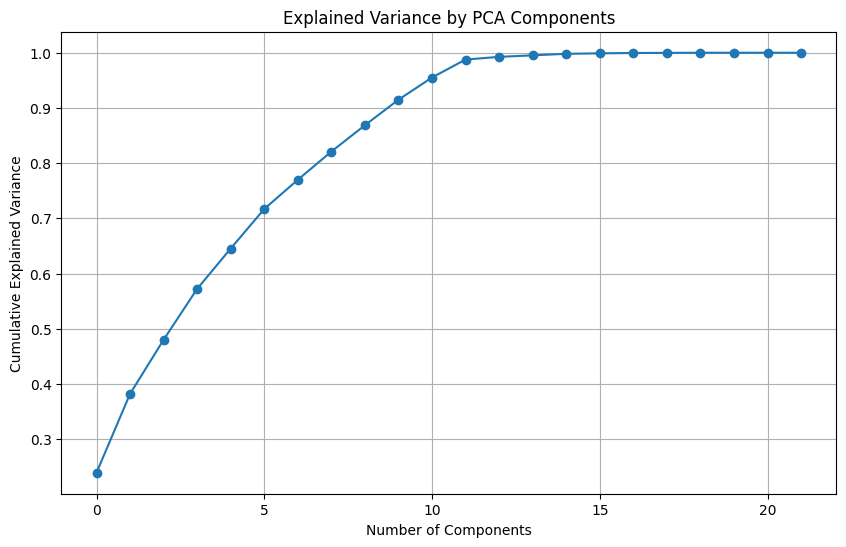

In [ ]:
# Fit PCA
pca = PCA()
pca.fit(scaled_features)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

In [ ]:
# Find number of components to explain ~95% variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

Number of components to retain 95% variance: 11


In [ ]:
# Apply PCA with optimal components
pca = PCA(n_components=n_components)
pca_transformed = pca.fit_transform(scaled_features)

# Convert to DataFrame for inspection
pca_df = pd.DataFrame(
    pca_transformed,
    columns=[f"PC{i+1}" for i in range(n_components)],
)

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
0,-3.718088,0.092585,-0.710162,0.822248,-2.317808,-0.572951,-0.248262,0.020708,-0.492191,-0.222130,-0.475142
1,-3.727857,0.309876,-0.121949,0.656888,0.295474,0.949203,-1.451356,0.863550,-1.621690,-0.308584,0.106674
2,-3.564354,-1.243480,-0.910700,-1.154211,1.278806,-0.762843,0.108850,0.373829,-0.192260,-0.122373,-0.506139
3,-3.504912,-1.333794,-0.757451,0.074026,-1.209443,-2.283083,1.000481,-0.859623,0.130193,-0.206231,-0.776503
4,-3.927734,0.755615,1.029593,-1.492967,0.413728,0.902963,1.343682,-1.252716,0.360201,-0.745343,0.945364


In [ ]:
# Set a reproducible random state
RANDOM_STATE = 666
rng = np.random.default_rng(seed=RANDOM_STATE)

# Subsample size for silhouette scoring and spectral clustering
subsample_size = 10_000
X_pca = pca_df.copy()

# Subsample for silhouette score and spectral clustering
sample_idx = rng.choice(
    X_pca.shape[0],
    size=min(subsample_size, X_pca.shape[0]),
    replace=False,
)

X_pca_sample = X_pca.iloc[sample_idx]

# Prepare to store results
k_values = range(2, 11)
results = []

# fmt:off
for k in k_values:
    print(f"\nEvaluating k = {k}...")

    # MiniBatch KMeans
    print("  MiniBatchKMeans clustering...")
    mb_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=RANDOM_STATE) 
    kmeans_labels = mb_kmeans.fit_predict(X_pca)

    print("  Evaluating MiniBatchKMeans...")
    k_sil = silhouette_score(X_pca_sample, kmeans_labels[sample_idx])
    k_ch = calinski_harabasz_score(X_pca, kmeans_labels)
    k_db = davies_bouldin_score(X_pca, kmeans_labels)

    # Spectral Clustering
    print("  Spectral Clustering (on sample)...")
    spectral = SpectralClustering(n_clusters=k, affinity="nearest_neighbors", random_state=RANDOM_STATE, n_jobs=-1)
    spectral_labels = spectral.fit_predict(X_pca_sample)

    print("  Evaluating Spectral Clustering...")
    s_sil = silhouette_score(X_pca_sample, spectral_labels)
    s_ch = calinski_harabasz_score(X_pca_sample, spectral_labels)
    s_db = davies_bouldin_score(X_pca_sample, spectral_labels)

    results.append(
        {
            "k": k,
            "MiniBatchKMeans_Silhouette": k_sil,
            "MiniBatchKMeans_CH": k_ch,
            "MiniBatchKMeans_DB": k_db,
            "Spectral_Silhouette": s_sil,
            "Spectral_CH": s_ch,
            "Spectral_DB": s_db,
        }
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df


Evaluating k = 2...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 3...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 4...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 5...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 6...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 7...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 8...
  MiniBatchKMeans clustering...

,k,MiniBatchKMeans_Silhouette,MiniBatchKMeans_CH,MiniBatchKMeans_DB,Spectral_Silhouette,Spectral_CH,Spectral_DB
0,2,0.172814,21731.279307,2.032743,0.264130,542.714394,1.608601
1,3,0.133254,15378.500026,2.318112,0.178499,1465.341709,1.802792
2,4,0.096611,12641.904085,2.577229,0.122306,1225.620899,2.104104
3,5,0.095849,11053.035316,2.403564,0.115077,1068.630730,2.126295
4,6,0.076074,9702.785501,2.349331,0.115614,886.604389,2.173811
5,7,0.073474,8803.402916,2.371969,0.091601,874.271188,2.175975
6,8,0.087294,8548.543585,2.259655,0.086068,825.498629,2.187813
7,9,0.078212,7981.866430,2.222863,0.091818,775.770010,2.140485
8,10,0.076586,7405.763922,2.231611,0.080738,718.681265,2.093595


In [ ]:
X_no_pca = scaled_features.copy()
X_no_pca_sample = X_no_pca[sample_idx]

results = []

# fmt:off
for k in k_values:
    print(f"\nEvaluating k = {k}...")

    # MiniBatch KMeans
    print("  MiniBatchKMeans clustering...")
    mb_kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=RANDOM_STATE) 
    kmeans_labels = mb_kmeans.fit_predict(X_no_pca)

    print("  Evaluating MiniBatchKMeans...")
    k_sil = silhouette_score(X_no_pca_sample, kmeans_labels[sample_idx])
    k_ch = calinski_harabasz_score(X_no_pca, kmeans_labels)
    k_db = davies_bouldin_score(X_no_pca, kmeans_labels)

    # Spectral Clustering
    print("  Spectral Clustering (on sample)...")
    spectral = SpectralClustering(n_clusters=k, affinity="nearest_neighbors", random_state=RANDOM_STATE, n_jobs=-1)
    spectral_labels = spectral.fit_predict(X_no_pca_sample)

    print("  Evaluating Spectral Clustering...")
    s_sil = silhouette_score(X_no_pca_sample, spectral_labels)
    s_ch = calinski_harabasz_score(X_no_pca_sample, spectral_labels)
    s_db = davies_bouldin_score(X_no_pca_sample, spectral_labels)

    results.append(
        {
            "k": k,
            "MiniBatchKMeans_Silhouette": k_sil,
            "MiniBatchKMeans_CH": k_ch,
            "MiniBatchKMeans_DB": k_db,
            "Spectral_Silhouette": s_sil,
            "Spectral_CH": s_ch,
            "Spectral_DB": s_db,
        }
    )

# Convert to DataFrame
results_no_pca_df = pd.DataFrame(results)
results_no_pca_df


Evaluating k = 2...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 3...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 4...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 5...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 6...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 7...
  MiniBatchKMeans clustering...
  Evaluating MiniBatchKMeans...
  Spectral Clustering (on sample)...
  Evaluating Spectral Clustering...

Evaluating k = 8...
  MiniBatchKMeans clustering...

,k,MiniBatchKMeans_Silhouette,MiniBatchKMeans_CH,MiniBatchKMeans_DB,Spectral_Silhouette,Spectral_CH,Spectral_DB
0,2,0.165446,20556.206684,2.094534,0.256335,516.717349,1.652370
1,3,0.122565,14275.491638,2.421679,0.170176,1378.467504,1.858275
2,4,0.086225,11863.346479,2.579027,0.107799,1174.654455,2.108724
3,5,0.085224,10331.218858,2.433166,0.107001,912.118504,2.196216
4,6,0.070978,8947.877806,2.489590,0.106272,844.733907,2.213781
5,7,0.068044,7988.187473,2.523581,0.084049,819.141965,2.243032
6,8,0.064427,7292.969360,2.396444,0.078427,751.880304,2.242713
7,9,0.061976,6695.224347,2.489367,0.078206,708.509598,2.219888
8,10,0.070483,6882.535765,2.321178,0.083116,672.662375,2.165064
